<a href="https://colab.research.google.com/github/24sotutakahashi/Music_predict/blob/main/%E6%A5%BD%E6%9B%B2%E3%81%AE%E3%82%B8%E3%83%A3%E3%83%B3%E3%83%AB%E6%8E%A8%E5%AE%9A%E3%83%81%E3%83%A3%E3%83%AC%E3%83%B3%E3%82%B8%EF%BC%81%EF%BC%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**はじめに**

３年次の７月に、SIGNATE上の「【SOTA Challenge 】SIGNATE Student Cup 2021春：楽曲のジャンル推定チャレンジ！！」というデータ分析コンペティションで、162人中19位となった。

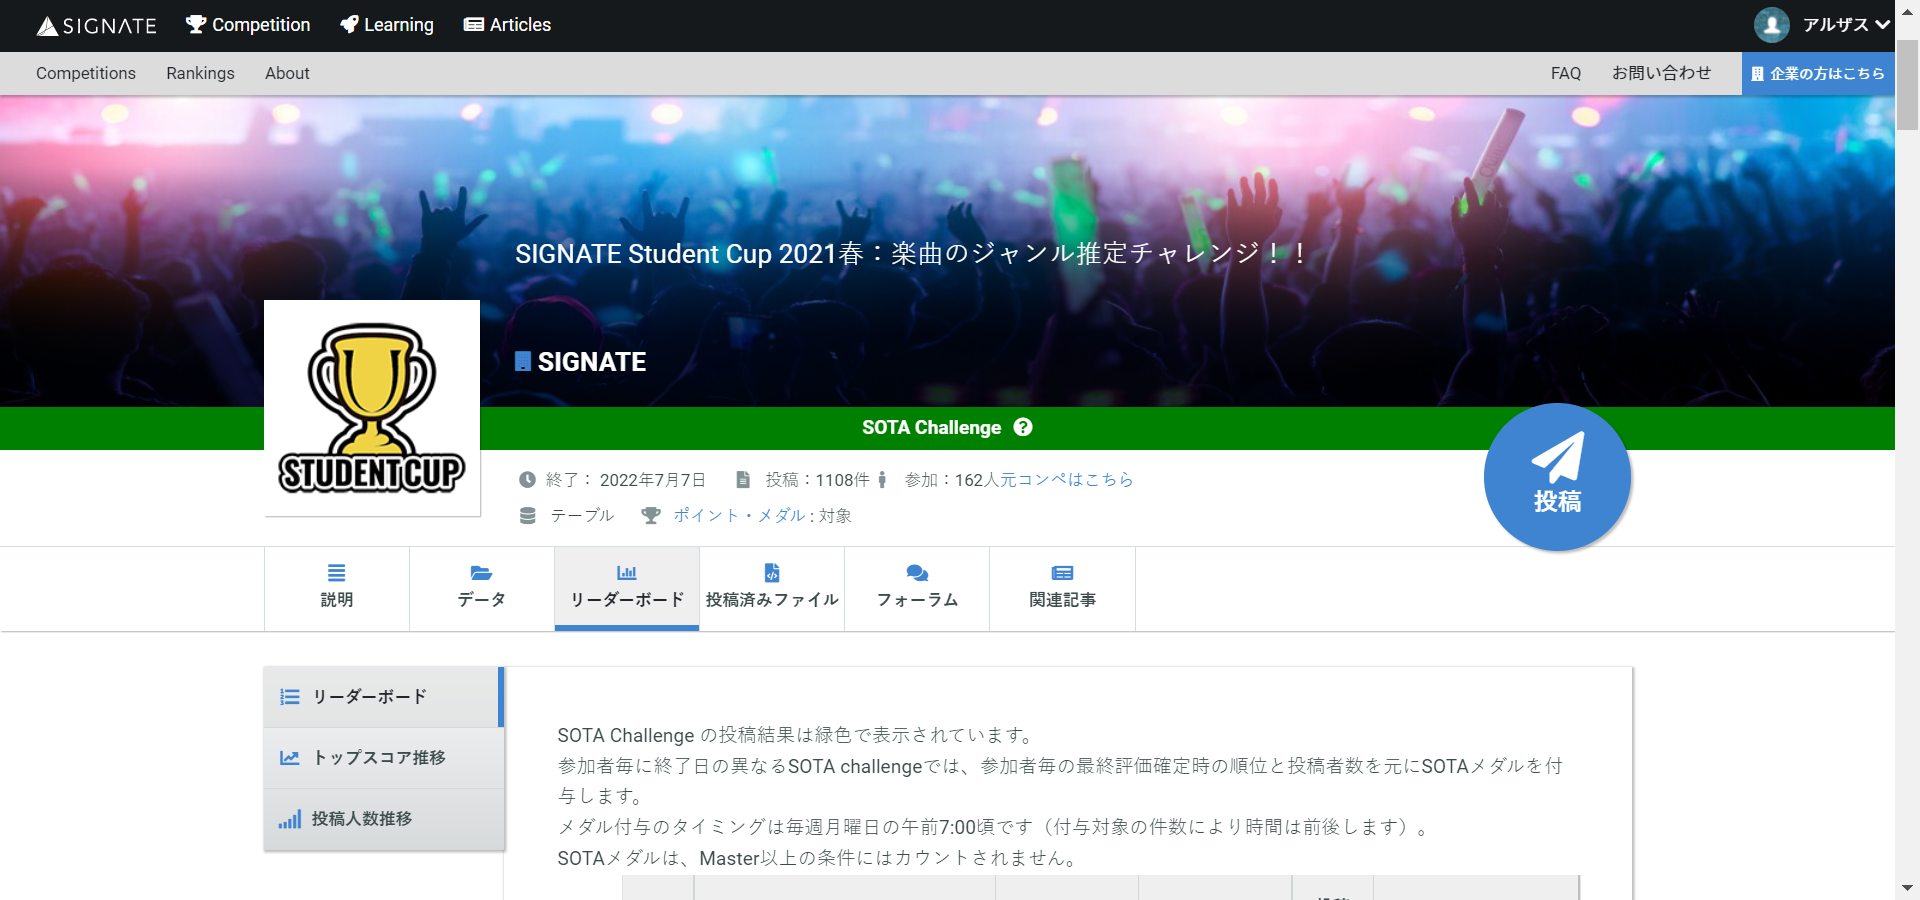

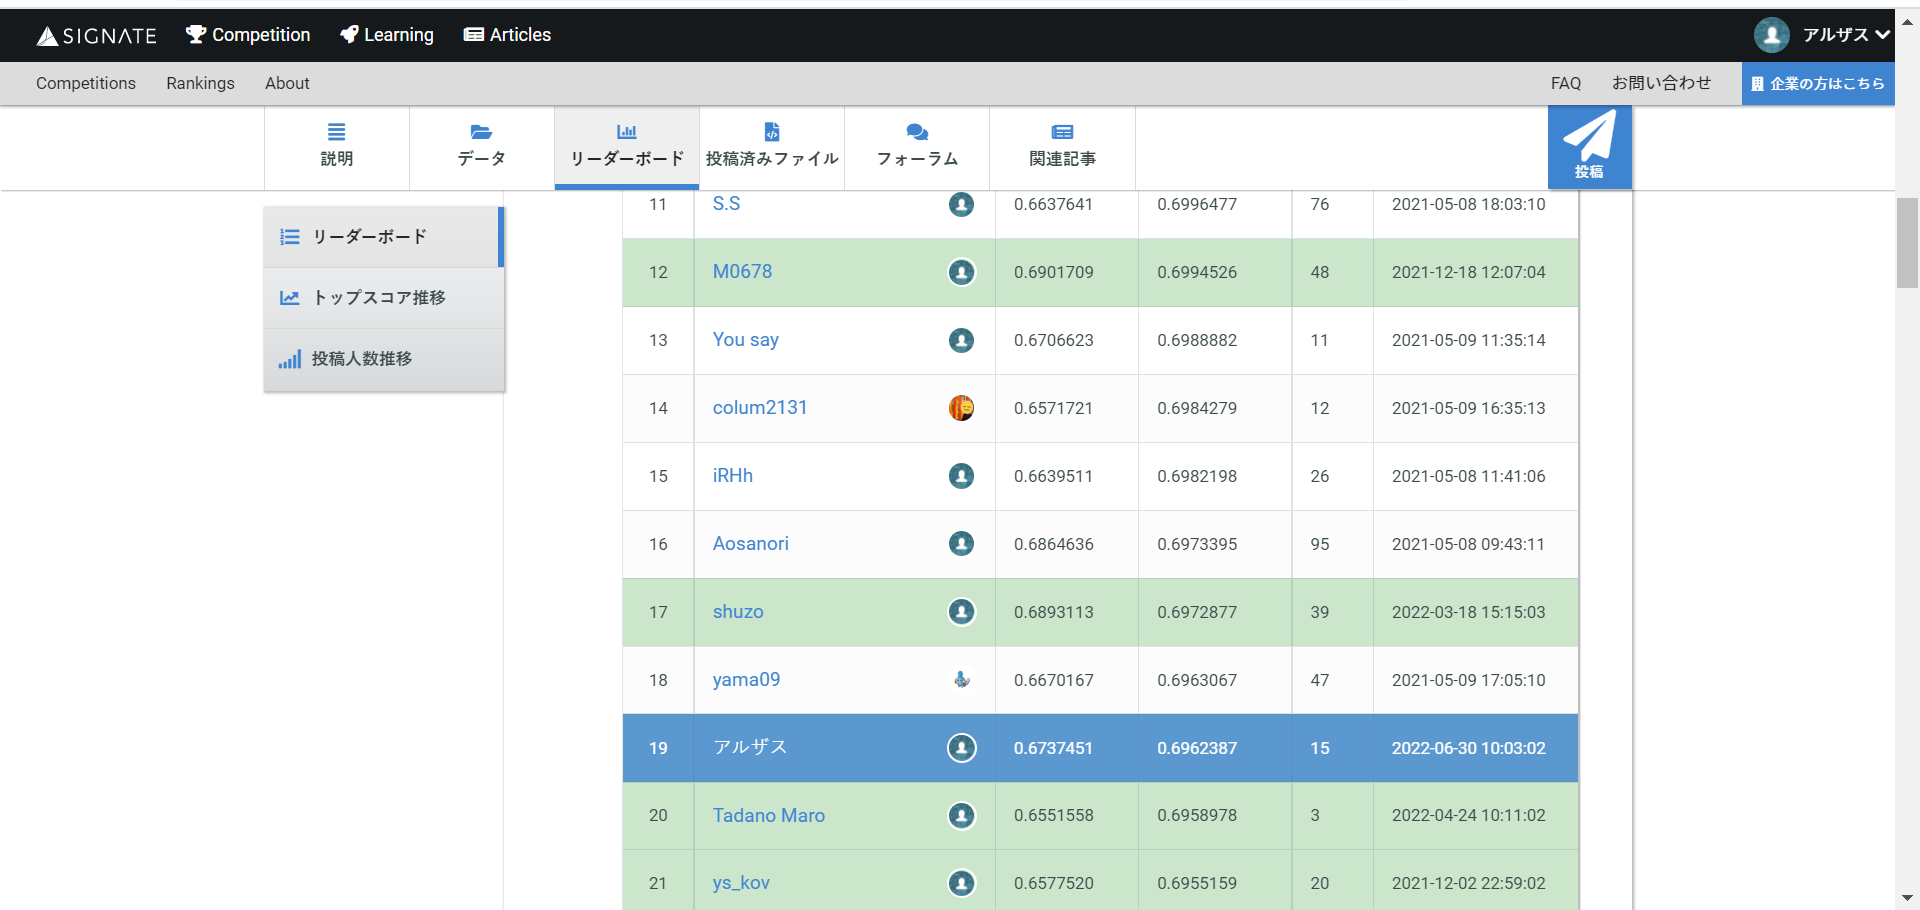

分析方法を簡単に述べると、主に4つの段階から成る。

①全ての特徴量を標準化する。

②その標準化した特徴量を用いて、kNNで特徴量を生成する。

③kNNで生成した特徴量と元々の特徴量を用いて、
k分割交差検証を使ったLightGBMでの学習を行う。

④予測結果の提出をする。

#**Google Driveのマウント**

In [67]:
#Google Driveをマウントしてアクセスできるようにします。
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    mount_dir = "/content/drive"
    drive.mount(mount_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**ライブラリと配布されたデータのインポート**

In [68]:
#ライブラリのインポート
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt

import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')

In [69]:
#SIGNAGEで配布されたデータを、それぞれインポート
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/楽曲コンペ/train (3).csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/楽曲コンペ/test (3).csv")
df_sample_sub = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/楽曲コンペ/sample_submit (3).csv", header=None)
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/楽曲コンペ/genre_labels (1).csv")

#**前処理**

In [70]:
#testデータとtrainデータの結合（操作を同時に行うために）
def merge_train_test(df_train, df_test):
    #testデータには目的変数の"genre"が無く、結合をエラー無くできるように値を埋める。
    if "genre" not in list(df_test.columns):
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

#testデータとtrainデータに分け戻す
def split_train_test(df):
    #"genre"の値で分け戻す
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test


In [71]:
#testデータとtrainデータの結合して、dfに入れる
df = merge_train_test(df_train, df_test)

In [72]:
#特徴量を扱いやすくする。

#genreと名前を対応づけて、["genre_name"] として扱ってる
df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

#tempoを標準化するために、tempoの範囲の平均をtempoとする。
df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)

#それぞれのregionを0と1で判断できるような変数を作る。またunkownは"region_unknown"に設定する。
df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)

# 特徴量の標準化
for col in [
    'popularity', 'duration_ms', 'acousticness',
       'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
       'speechiness', 'instrumentalness', 'tempo'
]:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]

In [73]:
#特徴量を扱いやすくしたので、testデータとtrainデータに分け戻す
df_train, df_test = split_train_test(df)

#targetに、trainデータの目的変数を入れる
target = df_train["genre"]

#**kNNによる特徴量生成**

In [74]:
class GroupFeatureExtractor:
    EX_TRANS_METHODS = ["deviation", "zscore"]
    
    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values

        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df_train, y=None):
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_column_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()


    def transform(self, df_eval):
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how="left")
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if "deviation" in self.ex_trans_methods:
                df_features[self._get_agg_column_names("deviation")] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")
            if "zscore" in self.ex_trans_methods:
                df_features[self._get_column_names("zscore")] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")) \
                                                                / (df_eval[[key]+self.group_values].groupby(key).transform("std") + 1e-8)
        df_features.drop(self.group_key, axis=1, inplace=True)
        return df_features

    def _get_column_names(self, method):
        return [f"agg_{method}_{col}_grpby_{self.group_key}" for col in self.group_values]

    def fit_transform(self, df_train, y=None):
        self.fit(df_train, y=y)
        return self.transform(df_train)

In [75]:
#kNNでの特徴量生成に使う特徴量をfeaturesに入れる
features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'region_unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
]

#kNNでの特徴量生成を、neighborsごとに分けて生成する。それぞれで、11個(N_CLASSESの部分)の特徴量を生成
N_CLASSES=11
N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

for n_neighbors in [2,5,10,20]:

    train_knn_name = "train_n" + str(n_neighbors) + "_oof"
    test_knn_name = "test_n" + str(n_neighbors) +"_predictions"

     # Null値の穴埋めを考える
    df_train = df_train[features].fillna(df_train[features].median())
    df_test = df_test[features].fillna(df_train[features].median())

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
    oof = np.zeros((len(df_train), N_CLASSES))
    predictions = np.zeros((len(df_test), N_CLASSES))
    df_feature_importance = pd.DataFrame()

    for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
        print(f"------------------------------ fold {fold_} ------------------------------")

        print(target.values)
        df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
        df_val = df_train.loc[indexes_val].reset_index(drop=True)
        target_trn = target.loc[indexes_trn].reset_index(drop=True)
        target_val = target.loc[indexes_val].reset_index(drop=True)
      
        model = KNeighborsClassifier(n_neighbors + 1, weights="distance", algorithm="ball_tree")    
        model.fit(df_trn, target_trn)
        distances, indexes = model.kneighbors(df_trn)
        prediction = model.predict(df_val)
        score = f1_score(target_val, prediction, average="macro")
        print(f"f1_score={score}\n")
        
        print(df_val.shape)
        print(model.predict_proba(df_val).shape)
       

        predictions += model.predict_proba(df_test) / N_SPLITS
    
    df_test["prediction"] = predictions.argmax(1)
    score = f1_score(target, oof.argmax(1), average="macro")

    
    print(train_knn_name)
    if train_knn_name == "train_n2_oof":
        train_n2_oof, test_n2_predictions = oof, predictions
    elif train_knn_name == "train_n5_oof":
        train_n5_oof, test_n5_predictions = oof, predictions
    elif train_knn_name == "train_n10_oof":
        train_n10_oof, test_n10_predictions = oof, predictions
    elif train_knn_name == "train_n20_oof":
        train_n20_oof, test_n20_predictions = oof, predictions

------------------------------ fold 0 ------------------------------
[10  8  3 ... 10 10  3]
f1_score=0.454440483824842

(270, 31)
(270, 11)
------------------------------ fold 1 ------------------------------
[10  8  3 ... 10 10  3]
f1_score=0.576574009478101

(270, 31)
(270, 11)
------------------------------ fold 2 ------------------------------
[10  8  3 ... 10 10  3]
f1_score=0.5343725290226502

(270, 31)
(270, 11)
------------------------------ fold 3 ------------------------------
[10  8  3 ... 10 10  3]
f1_score=0.4970980104193291

(270, 31)
(270, 11)
------------------------------ fold 4 ------------------------------
[10  8  3 ... 10 10  3]
f1_score=0.41174000008916267

(270, 31)
(270, 11)
------------------------------ fold 5 ------------------------------
[10  8  3 ... 10 10  3]
f1_score=0.4711952790471342

(270, 31)
(270, 11)
------------------------------ fold 6 ------------------------------
[10  8  3 ... 10 10  3]
f1_score=0.5125453851186474

(270, 31)
(270, 11)
-------

In [76]:
#生成した特徴量の名前の設定
col_dict = {}
for knn_name in ["knn2", "knn5","knn10", "knn20"]:
  knn_cols = []
  for i in range(N_CLASSES):
    knn_cols.append(knn_name + "_" + str(i))
    col_dict[knn_name] = knn_cols

In [77]:
#neighborsごとにデータを格納
train_n2_df = pd.DataFrame(train_n2_oof, columns=col_dict["knn2"])
train_n5_df = pd.DataFrame(train_n5_oof, columns=col_dict["knn5"])
train_n10_df = pd.DataFrame(train_n10_oof, columns=col_dict["knn10"])
train_n20_df = pd.DataFrame(train_n20_oof, columns=col_dict["knn20"])

test_n2_df = pd.DataFrame(test_n2_predictions, columns=col_dict["knn2"])
test_n5_df = pd.DataFrame(test_n5_predictions, columns=col_dict["knn5"])
test_n10_df = pd.DataFrame(test_n10_predictions, columns=col_dict["knn10"])
test_n20_df = pd.DataFrame(test_n20_predictions, columns=col_dict["knn20"])

#上記のデータを、横方向に結合
layer1_train = pd.concat([train_n2_df, train_n5_df, train_n10_df, train_n20_df], axis=1)
layer1_test = pd.concat([test_n2_df, test_n5_df, test_n10_df, test_n20_df], axis=1)

#**k分割交差検証を使い、LightGBMで学習。**

------------------------------ fold 0 ------------------------------
Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 1.35375	valid_1's multi_logloss: 1.37492
[600]	training's multi_logloss: 1.26305	valid_1's multi_logloss: 1.31414
[900]	training's multi_logloss: 1.21567	valid_1's multi_logloss: 1.28866
[1200]	training's multi_logloss: 1.18326	valid_1's multi_logloss: 1.2757
[1500]	training's multi_logloss: 1.15744	valid_1's multi_logloss: 1.27121
[1800]	training's multi_logloss: 1.13472	valid_1's multi_logloss: 1.26776
[2100]	training's multi_logloss: 1.11451	valid_1's multi_logloss: 1.26435
[2400]	training's multi_logloss: 1.09602	valid_1's multi_logloss: 1.26297
[2700]	training's multi_logloss: 1.07845	valid_1's multi_logloss: 1.26315
Early stopping, best iteration is:
[2415]	training's multi_logloss: 1.09514	valid_1's multi_logloss: 1.26287

------------------------------ fold 1 ------------------------------
Training until validation s

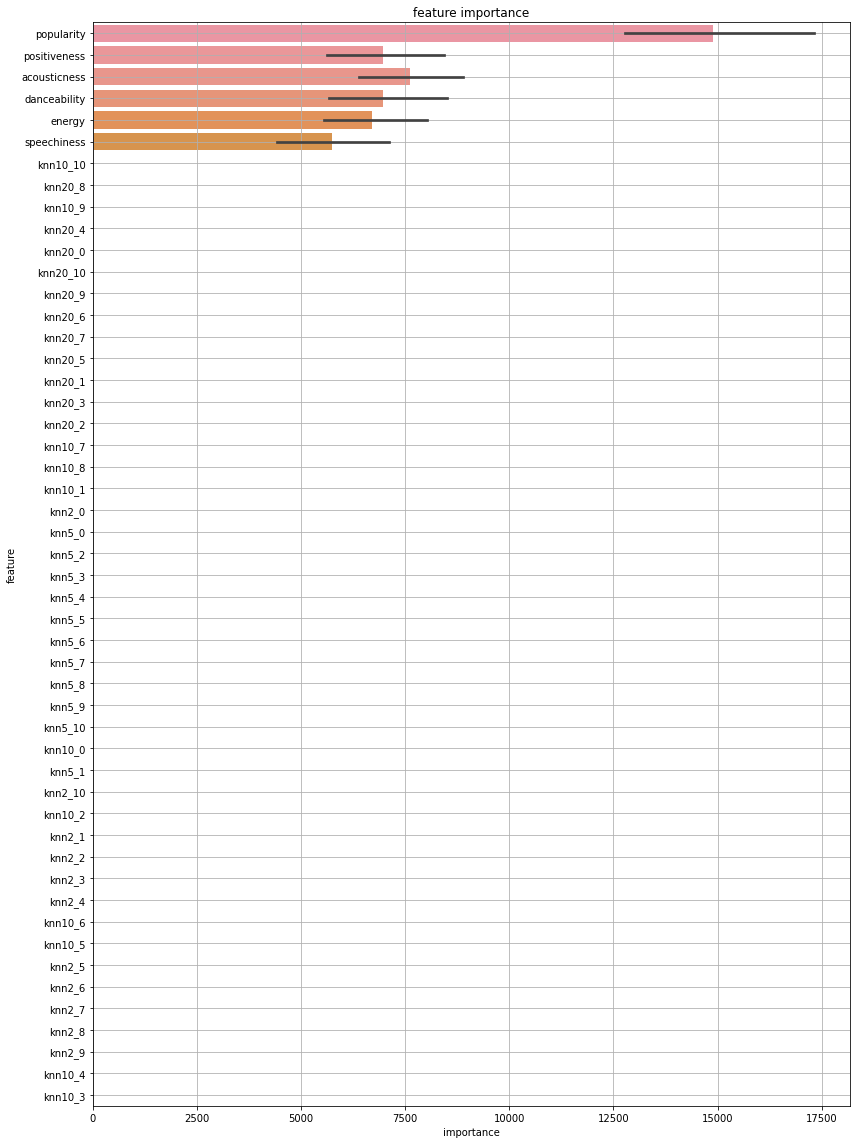

In [78]:
N_SPLITS = 15
SEED_SKF = 42


#元々の特徴量を使うので、元々のデータをインポート
df_trains_ori = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/楽曲コンペ/train (3).csv")
df_tests_ori = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/楽曲コンペ/test (3).csv")

original_cols = [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "speechiness",
    "popularity",
]
layer1_cols=[
        'knn2_0', 'knn2_1', 'knn2_2', 'knn2_3', 'knn2_4', 'knn2_5', 'knn2_6',
       'knn2_7', 'knn2_8', 'knn2_9', 'knn2_10', 'knn5_0', 'knn5_1', 'knn5_2',
       'knn5_3', 'knn5_4', 'knn5_5', 'knn5_6', 'knn5_7', 'knn5_8', 'knn5_9',
       'knn5_10', 'knn10_0', 'knn10_1', 'knn10_2', 'knn10_3', 'knn10_4',
       'knn10_5', 'knn10_6', 'knn10_7', 'knn10_8', 'knn10_9', 'knn10_10',
       'knn20_0', 'knn20_1', 'knn20_2', 'knn20_3', 'knn20_4', 'knn20_5',
       'knn20_6', 'knn20_7', 'knn20_8', 'knn20_9', 'knn20_10'
       ]

#訓練データにおいて、元々の特徴量とkNNで生成した特徴量を、結合する
df_train = pd.concat([df_trains_ori[original_cols], layer1_train], axis=1)

#テストデータにおいて、元々の特徴量とkNNで生成した特徴量を、結合する
df_test = pd.concat([df_tests_ori[original_cols], layer1_test], axis=1)

#今回学習にしようする元々の特徴量とkNNで生成した特徴量を、featuresに入れる。
features = original_cols + layer1_cols

features_categorical=[]

#パラメータのチューニング
learning_rate = 0.01

lgb_params = {
    "objective": "multiclass",
    "num_class": N_CLASSES,
    "learning_rate": learning_rate,
    "num_leaves": 3,
    "min_data_in_leaf": 40,
    "verbosity": 0,
    "seed": 42,
}

#k分割交差検証を使って、LightGBMで学習
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros((len(df_train), N_CLASSES))
predictions = np.zeros((len(df_test), N_CLASSES))

df_feature_importance = pd.DataFrame()

for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
   

    print(f"------------------------------ fold {fold_} ------------------------------")
    df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
    df_val = df_train.loc[indexes_val].reset_index(drop=True)

    target_trn = target.loc[indexes_trn].reset_index(drop=True)
    target_val = target.loc[indexes_val].reset_index(drop=True)
    
    lgb_train = lgb.Dataset(
            df_trn.loc[:, features],
          label=target_trn,
          categorical_feature=features_categorical
      )
    lgb_valid = lgb.Dataset(
          df_val.loc[:, features],
          label=target_val,
          categorical_feature=features_categorical
      )
      
    lgb_params["learning_rate"] = learning_rate

    num_round = 999999999

    model = lgb.train(
          lgb_params,
          lgb_train, 
          num_round, 
          valid_sets=[lgb_train, lgb_valid], 
          verbose_eval=300,
          early_stopping_rounds=300 if num_round >= 1e8 else None,
          fobj=None
      )
      
      # cv
    prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round  # おまじない
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)
      
    #特徴量の重要度を設定
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)
      

    #平均を、予測結果にいれる
    predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
    print()

#一番確信度が高いラベルを予測結果として採用。
df_test["prediction"] = predictions.argmax(1)

#スコアを表示
score = f1_score(target, oof.argmax(1), average="macro")
print("CV score")
print(f"  f1: {score:8.5f}")
print()
print(classification_report(target, oof.argmax(1)))

#先ほど設定した特徴量のt(classification_report(target, oof.argmax(1)))

#先ほど設定した特徴量の重要度を描画
plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("feature importance")
plt.grid()
plt.tight_layout()
plt.show()


# 予測値とテストの値をそれぞれlayer2_train_pred、layer2_test_predにいれる。
layer2_train_pred, layer2_test_pred = oof, predictions

In [79]:
df_test["prediction"]

0        8
1       10
2        8
3        8
4        8
        ..
4041    10
4042     8
4043     8
4044     8
4045     8
Name: prediction, Length: 4046, dtype: int64

#**予測結果を提出ファイルに入れ、csvファイルとして出力。**

In [80]:
df_test["prediction"] = layer2_test_pred.argmax(1)
df_submission = df_sample_sub.copy()

In [81]:
df_submission["genre"] = df_test["prediction"]

assert not df_submission["genre"].isna().any()

In [82]:
#提出ファイルをCSVとして出力
df_submission.to_csv("submission5.csv", header=None, index=False)